<a href="https://colab.research.google.com/github/ppkgtmm/emotion/blob/LSTM/emo_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q keras-tuner
# !rm -r emotion
# !git clone --branch LSTM https://github.com/ppkgtmm/emotion.git emotion

In [3]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import  Tokenizer
from emotion.models import utils, lstm
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperParameters

In [4]:
num_words = 15000
max_len = 300
hp = HyperParameters()
hp.Choice('output_dim',[128, 256])
hp.Choice('optimizer', ['adam', 'amsgrad'])
hp.Choice('lstm_units', [16, 32, 64, 128])
hp.Fixed('max_len', max_len)
hp.Fixed('num_words', num_words)
seed = 1234

In [7]:
train, test = utils.read_and_split()
train.sample(5)

,text,target
10357,i feel this urge to update because i resigned ...,sadness
12165,i feel threatened i feel fear,fear
1797,i am feeling very shaky,fear
6230,i liked just talking to someone and that butte...,love
9951,ive been feeling kinda crappy the last couple ...,sadness


In [8]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [9]:
sequence_train = utils.get_sequences(tokenizer, train['text'], max_len)
sequence_test = utils.get_sequences(tokenizer, test['text'], max_len)

In [10]:
target_train = utils.OH_fit_transform(train['target'])
target_test = utils.OH_transform(test['target'])

In [11]:
tuner = BayesianOptimization( lstm.build_lstm,
                              'val_accuracy',
                              16,
                              executions_per_trial=2,
                              hyperparameters=hp, 
                              seed=seed,
                              num_initial_points=5,
                              project_name='/content/drive/MyDrive/__ed__/lstm_B32',
                            )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 128)          1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 16)                9280      
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
Total params: 1,929,382
Trainable params: 1,929,382
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = tuner.search(
    sequence_train, target_train,
    validation_split=0.1,
    epochs=3
)

Trial 16 Complete [00h 02m 56s]
val_accuracy: 0.9244117438793182

Best val_accuracy So Far: 0.9288235306739807
Total elapsed time: 00h 42m 57s
INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
output_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'amsgrad'], 'ordered': False}
lstm_units (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
max_len (Fixed)
{'conditions': [], 'value': 300}
num_words (Fixed)
{'conditions': [], 'value': 15000}


In [14]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/__ed__/lstm_B32
Showing 3 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9288235306739807
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9288235306739807
Trial summary
Hyperparameters:
output_dim: 256
optimizer: amsgrad
lstm_units: 128
max_len: 300
num_words: 15000
Score: 0.9276470839977264


In [15]:
best_model = tuner.get_best_models(num_models=1)[0]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 256)          3840000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 4,037,894
Trainable params: 4,037,894
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


94/94 [==============================] - 1s 8ms/step
Accuracy:	91.6%


              precision    recall  f1-score   support

           0       0.90      0.94      0.92       406
           1       0.91      0.85      0.88       356
           2       0.95      0.91      0.93      1014
           3       0.82      0.85      0.83       246
           4       0.94      0.97      0.95       870
           5       0.73      0.83      0.78       108

    accuracy                           0.92      3000
   macro avg       0.88      0.89      0.88      3000
weighted avg       0.92      0.92      0.92      3000



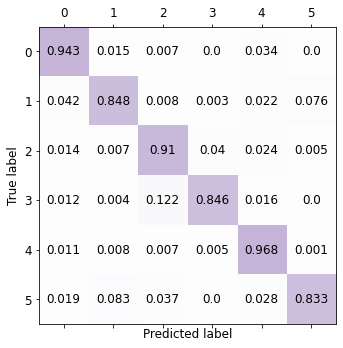

In [16]:
utils.model_evaluate(best_model, sequence_test, target_test, 32)

In [18]:
# best_model.save('best_lstm.h5')
# utils.dump(tokenizer,'/content/drive/MyDrive/__ed__/lstm_B32/tokenizer.pickle')

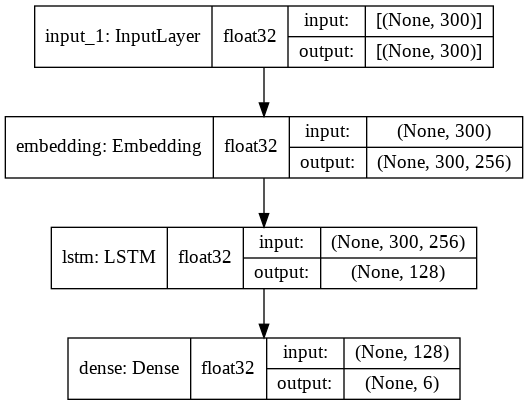

In [17]:
from keras.utils import plot_model
plot_model(
    best_model,
    to_file='/content/drive/MyDrive/__ed__/lstm_B32/plot.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True
    )